# Regularization

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
% matplotlib inline

from scipy.special import expit
import scipy.sparse as sps
from scipy import stats

from pyglmnet import GLM

/Users/pavanramkumar/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(labelsize=14)

In [3]:
data_source = 'pyglmnet' # can also be 'sklearn' or 'crimedata'

### Simulate with `pyglmnet`

In [4]:
if data_source == 'pyglmnet':
    N = 200
    p = 500
    corr_predictors = False
    
    D = dict()
    D['coef'] = dict()

    # Predictors
    D['X'] = np.random.randn(N, p)

    # Make the predictors correlated predictors
    if corr_predictors==True:
        W = sps.random(p,p, density=0.4).toarray()
        D['X'] = np.dot(D['X'], W)
    
    # Coefficients
    rvs = stats.norm(loc=0.0, scale=1.0).rvs
    D['coef']['beta0'] = 0.1
    tmp = sps.random(p,1,density=0.01, data_rvs=rvs)
    D['coef']['beta'] = np.squeeze(tmp.toarray())

    # Targets
    glm_simulator = GLM(distr='binomial')
    D['y'] = glm_simulator.simulate(D['coef']['beta0'], D['coef']['beta'], D['X'])

### Split into training and validation sets

In [5]:
from sklearn.cross_validation import train_test_split
Xtrain, Xval, ytrain, yval = train_test_split(D['X'], D['y'].reshape(-1, 1), test_size=0.5)

### Fit the model

In [11]:
glm = GLM(distr='binomial', 
          reg_lambda=np.logspace(np.log(5e-1), np.log(1e-3), 50, base=np.exp(1)),
          alpha=1.0)
glm.fit(Xtrain, ytrain)

<
Distribution | binomial
alpha | 1.00
max_iter | 1000.00
lambda: 0.50 to 0.00
>

### Regularization path

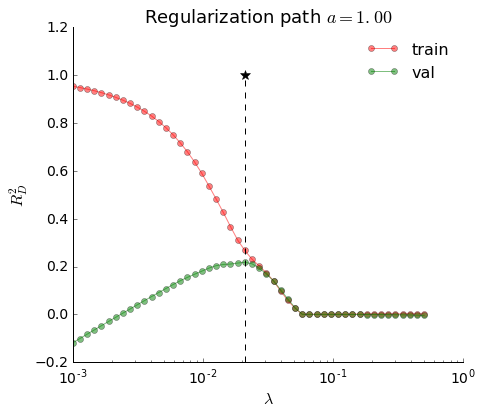

In [12]:
R2r = list()
R2v = list()

for l, m in enumerate(glm.reg_lambda):
    ytrain_hat = glm[l].predict(Xtrain)
    yval_hat = glm[l].predict(Xval)
    R2r.append(glm[l].score(np.squeeze(ytrain), np.squeeze(ytrain_hat), np.mean(ytrain), 'pseudo_R2'))
    R2v.append(glm[l].score(np.squeeze(yval), np.squeeze(yval_hat), np.mean(ytrain), 'pseudo_R2'))

plt.figure(figsize=(7, 6))
ax = plt.subplot(111)
simpleaxis(ax)
plt.semilogx(glm.reg_lambda, R2r, 'ro-', alpha=0.5)
plt.semilogx(glm.reg_lambda, R2v, 'go-', alpha=0.5)
plt.ylim([-0.2, 1.2])
plt.title('Regularization path $a = %4.2f$' % glm.alpha, fontsize=18)
plt.xlabel('$\lambda$', fontsize=16)
plt.ylabel('$R_D^2$', fontsize=16)
plt.legend(['train', 'val'], fontsize=16, frameon=False, loc='upper right')

R2r = np.array(R2r)
R2v = np.array(R2v)
lopt = R2v.argmax()
plt.plot(glm.reg_lambda[lopt], 1.0, 'k*', ms=10)
plt.plot(glm.reg_lambda[lopt] * np.ones(10), np.linspace(-0.4, 1, 10), 'k--')
plt.show()

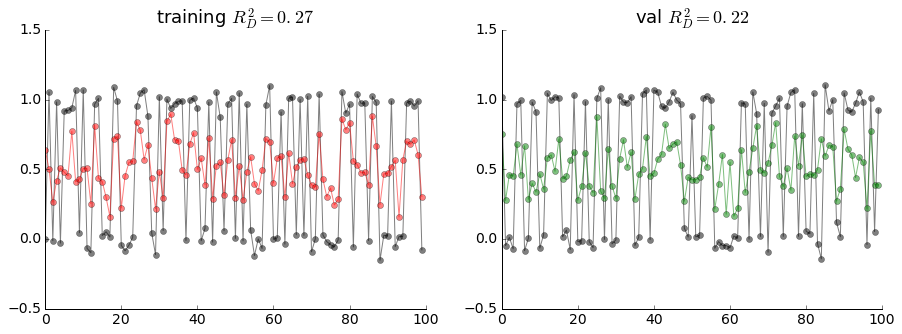

In [13]:
# Visualize training and test error vs. iterations
plt.figure(figsize=(15, 5))
# Training set prediction
ax = plt.subplot(121)
simpleaxis(ax)
ytrain_hat = glm[lopt].predict(Xtrain)
plt.plot(ytrain + 0.05 * np.random.randn(np.int(0.5 * np.float(N)), 1), 'ko-', alpha=0.5)
plt.plot(ytrain_hat, 'ro-', alpha=0.5)
plt.ylim([-0.5, 1.5])
plt.title("training $R_D^2 = %4.2f$" % R2r[lopt], fontsize=18)

# Test set prediction
ax = plt.subplot(122)
simpleaxis(ax)
yval_hat = glm[lopt].predict(Xval)

plt.plot(yval + 0.05 * np.random.randn(np.int(0.5 * np.float(N)), 1), 'ko-', alpha=0.5)
plt.plot(yval_hat, 'go-', alpha=0.5)
plt.ylim([-0.5, 1.5])
plt.title("val $R_D^2 = %4.2f$" % R2v[lopt], fontsize=18)

plt.show()

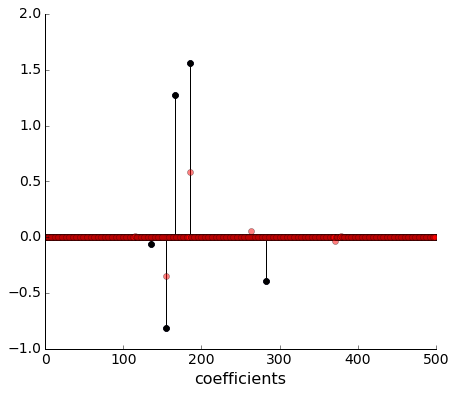

In [14]:
# Coefficients
plt.figure(figsize=(7,6))
ax = plt.subplot(111)
simpleaxis(ax)
plt.stem(np.arange(p), D['coef']['beta'], 'ko-', alpha=0.5)
plt.plot(np.arange(p), glm[lopt].fit_['beta'], 'ro', alpha=0.5)
plt.xlabel('coefficients', fontsize=16)
plt.show()

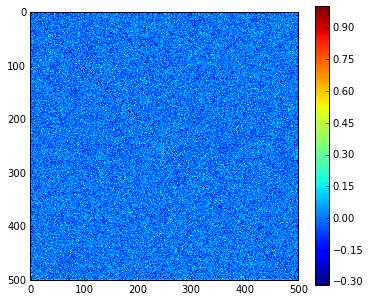

In [10]:
plt.figure(figsize=(6,5))
plt.imshow(np.corrcoef(np.transpose(D['X'])), interpolation='none')
plt.colorbar()
plt.show()